Intro

In [1]:
import requests
import pandas as pd

url_prefix = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-evaluation/'
docs_url = url_prefix + 'search_evaluation/documents-with-ids.json'
documents = requests.get(docs_url).json()

ground_truth_url = url_prefix + 'search_evaluation/ground-truth-data.csv'
df_ground_truth = pd.read_csv(ground_truth_url)
ground_truth = df_ground_truth.to_dict(orient='records')

In [24]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'id': 'c02e79ef'}

In [25]:
ground_truth[0]

{'question': 'When does the course begin?',
 'course': 'data-engineering-zoomcamp',
 'document': 'c02e79ef'}

In [4]:
from tqdm.auto import tqdm

def hit_rate(relevance_total):
    cnt = 0

    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)

def mrr(relevance_total):
    total_score = 0.0

    for line in relevance_total:
        for rank in range(len(line)):
            if line[rank] == True:
                total_score = total_score + 1 / (rank + 1)

    return total_score / len(relevance_total)

def evaluate(ground_truth, search_function):
    relevance_total = []

    for q in tqdm(ground_truth):
        doc_id = q['document']
        results = search_function(q)
        relevance = [d['id'] == doc_id for d in results]
        relevance_total.append(relevance)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
    }

Q1

In [5]:
import minsearch

index = minsearch.Index(
    text_fields=["question", "text", "section"],
    keyword_fields=["course", "id"]
)

index.fit(documents)

In [6]:
def minsearch_search(query, course):
    boost = {'question': 1.5, 'section': 0.1}

    results = index.search(
        query=query,
        filter_dict={'course': course},
        boost_dict=boost,
        num_results=5
    )

    return results

In [7]:
evaluate(ground_truth, lambda q: minsearch_search(q['question'], q['course']))

  0%|          | 0/4627 [00:00<?, ?it/s]

{'hit_rate': 0.848714069591528, 'mrr': 0.7288235717887772}

Q2

In [26]:
from minsearch import VectorSearch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

In [27]:
texts = []

for doc in documents:
    t = doc['question']
    texts.append(t)

pipeline = make_pipeline(
    TfidfVectorizer(min_df=3),
    TruncatedSVD(n_components=128, random_state=1)
)
X = pipeline.fit_transform(texts)

In [28]:
vindex = VectorSearch(keyword_fields={'course'})
vindex.fit(X, documents)

In [36]:
def minsearch_vector_search(query, course):
    query_vec = pipeline.transform([query])[0] 
    results = vindex.search(
        query_vec,
        filter_dict={'course': course},
        num_results=5
        )

    return results

In [37]:
evaluate(ground_truth, lambda q: minsearch_vector_search(q['question'], q['course']))

  0%|          | 0/4627 [00:00<?, ?it/s]

{'hit_rate': 0.48173762697212014, 'mrr': 0.3572833369353793}

In [35]:
help(VectorSearch)

Help on class VectorSearch in module minsearch.vector:

class VectorSearch(builtins.object)
 |  VectorSearch(keyword_fields)
 |
 |  A vector search index using cosine similarity for vector search and exact matching for keyword fields.
 |
 |  Takes a 2D numpy array of vectors and a list of payload documents, providing efficient
 |  similarity search with keyword filtering and boosting capabilities.
 |
 |  Methods defined here:
 |
 |  __init__(self, keyword_fields)
 |      Initialize the VectorSearch index.
 |
 |      Args:
 |          keyword_fields (list): List of keyword field names to index for exact matching.
 |
 |  fit(self, vectors, payload)
 |      Fits the index with the provided vectors and payload documents.
 |
 |      Args:
 |          vectors (np.ndarray): 2D numpy array of shape (n_docs, vector_dimension).
 |          payload (list of dict): List of documents to use as payload. Each document is a dictionary.
 |
 |  search(self, query_vector, filter_dict=None, num_results=10

Q3

In [39]:
texts = []

for doc in documents:
    t = doc['question'] + ' ' + doc['text']
    texts.append(t)

pipeline = make_pipeline(
    TfidfVectorizer(min_df=3),
    TruncatedSVD(n_components=128, random_state=1)
)
X = pipeline.fit_transform(texts)

In [40]:
vindex = VectorSearch(keyword_fields={'course'})
vindex.fit(X, documents)

In [41]:
def minsearch_vector_search(query, course):
    query_vec = pipeline.transform([query])[0] 
    results = vindex.search(
        query_vec,
        filter_dict={'course': course},
        num_results=5
        )

    return results

In [42]:
evaluate(ground_truth, lambda q: minsearch_vector_search(q['question'], q['course']))

  0%|          | 0/4627 [00:00<?, ?it/s]

{'hit_rate': 0.8210503566025502, 'mrr': 0.6717347453353508}

Q4

In [57]:
from qdrant_client import QdrantClient, models

In [58]:
qd_client = QdrantClient("http://localhost:6333")

In [59]:
EMBEDDING_DIMENSIONALITY = 512
model_handle = "jinaai/jina-embeddings-v2-small-en"

In [60]:
collection_name = "hw3-faq"

In [61]:
qd_client.delete_collection(collection_name=collection_name)

True

In [62]:
qd_client.create_collection(
    collection_name=collection_name,
    vectors_config=models.VectorParams(
        size=EMBEDDING_DIMENSIONALITY,
        distance=models.Distance.COSINE
    )
)

True

In [63]:
qd_client.create_payload_index(
    collection_name=collection_name,
    field_name="course",
    field_schema="keyword"
)

UpdateResult(operation_id=1, status=<UpdateStatus.COMPLETED: 'completed'>)

In [64]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'id': 'c02e79ef'}

In [65]:
points = []

for i, doc in enumerate(documents):
    text = doc['question'] + ' ' + doc['text']
    vector = models.Document(text=text, model=model_handle)
    point = models.PointStruct(
        id=i,
        vector=vector,
        payload=doc
    )
    points.append(point)

In [66]:
qd_client.upsert(
    collection_name=collection_name,
    points=points
)

UpdateResult(operation_id=2, status=<UpdateStatus.COMPLETED: 'completed'>)

In [67]:
def vector_search_qdrant(question, course):
    
    course = course
    query_points = qd_client.query_points(
        collection_name=collection_name,
        query=models.Document(
            text=question,
            model=model_handle 
        ),
        query_filter=models.Filter( 
            must=[
                models.FieldCondition(
                    key="course",
                    match=models.MatchValue(value=course)
                )
            ]
        ),
        limit=5,
        with_payload=True
    )
    
    results = []
    
    for point in query_points.points:
        results.append(point.payload)
    
    return results

In [68]:
evaluate(ground_truth, lambda q: vector_search_qdrant(q['question'], q['course']))

  0%|          | 0/4627 [00:00<?, ?it/s]

{'hit_rate': 0.9299762264966501, 'mrr': 0.8517722066133576}

Q 5

In [88]:
import numpy as np

In [89]:
url_prefix = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-evaluation/'
results_url = url_prefix + 'rag_evaluation/data/results-gpt4o-mini.csv'
df_results = pd.read_csv(results_url)
results_dict = df_results.to_dict(orient='records')

In [90]:
def normalize(u):
    norm = np.sqrt(u.dot(u))
    return u / norm

In [91]:
def cosine(u, v):
    u = normalize(u)
    v = normalize(v)
    return u.dot(v)

In [92]:
record = results_dict[0]
record

{'answer_llm': 'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [93]:
texts = []

for doc in results_dict:
    t = doc['answer_llm'] + ' ' + doc['answer_orig']  + ' ' + doc['question']
    texts.append(t)

pipeline = make_pipeline(
    TfidfVectorizer(min_df=3),
    TruncatedSVD(n_components=128, random_state=1)
)
pipeline.fit(texts)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(min_df=3)),
                ('truncatedsvd',
                 TruncatedSVD(n_components=128, random_state=1))])

In [94]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = pipeline.transform([answer_orig])[0]
    v_orig = pipeline.transform([answer_llm])[0]
    
    return cosine(v_llm,v_orig)

In [95]:
similarity = []

for record in tqdm(results_dict):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [96]:
df_results['cosine'] = similarity
df_results['cosine'].describe()

count    1830.000000
mean        0.841584
std         0.173737
min         0.079093
25%         0.806927
50%         0.905812
75%         0.950711
max         0.996457
Name: cosine, dtype: float64

In [97]:
import seaborn as sns

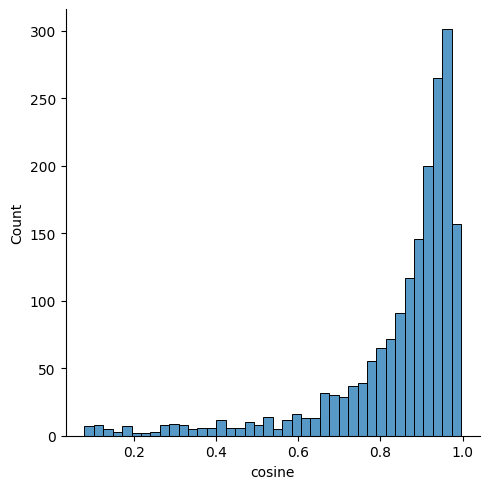

In [98]:
sns.displot(df_results['cosine'])

Q6